In [1]:
import torch
from torchvision import datasets, transforms
import copy 
import math
import numpy as np

train_loader= torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=64, shuffle=True) 
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=64, shuffle=True) 


ModuleNotFoundError: No module named 'torch'

In [2]:
#Appelons n la taille de x_train(entrée), c la taille de y_train(sortie), B la taille du batch
#L'implémentation en Torch est très rapide. D'autant plus si l'on écrit tout vectoriellement.
from torch.autograd import Function
class Flinear(Function):         
    def forward(self,x,theta):
        self.x=x #de taille:B,n
        self.theta = copy.copy(theta) #taille: n,c
        
        result=torch.mm(x,theta) #taille: B,c
        return(result)
   
    def backward(self, delta): #delta  taille: B,c
        grad_theta = torch.mm((self.x).t(),delta) #taille: n,c
        grad_x = torch.mm(delta,self.theta.t()) #taille: B,n
        return(grad_x, grad_theta) ;
               
class FMSE(Function) :    
    def forward(self,y_predit,y):
        self.y_predit=y_predit
        self.y=y
        self.dimension_sortie = (self.y_predit).size()[1]
        self.dimension_batch = (self.y_predit).size()[0]
        loss = torch.zeros(self.dimension_batch) #taille: B,1
        
        for k in range(0,self.dimension_batch) :
            loss[k] += ((y_predit[k]-y[k])**2).mean()
        return loss
    
    def backward(self, delta):
        grad = torch.zeros(self.dimension_batch,self.dimension_sortie) #taille: B,c
        grad = 2*(self.y_predit - self.y)
        return grad  

class FTanh(Function):        
    def forward(self,y,theta):
        self.y=y
        self.theta = theta
        
        self.result = np.tanh(y)
        return(self.result) #taille B,c
    
    def backward(self, delta):
        grad_theta = np.zeros((1,1)) #never mind
        grad_y = delta.mul(1-np.tanh(self.y)**2) #taille: B,c
        return(grad_y, grad_theta)
    
import time

# Voici un réseau à une couche: un module linéaire puis une fonction d'activation tanh

In [3]:
def Gradient_Descent(batch_size,learning_rate,taille_sortie,maxEpoch,random_value):
    train_loader= torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=batch_size, shuffle=True) 
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=batch_size, shuffle=True) 
    
    linear = Flinear()
    error = FMSE()
    tanh = FTanh()
    
    all_losses_global_train=np.zeros(int((maxEpoch)))
    all_losses_global_test=np.zeros(int((maxEpoch)))
    
    accuracy_train=np.zeros(int(maxEpoch))
    accuracy_test=np.zeros(int(maxEpoch))

    theta = torch.randn(28*28,10).uniform_(-random_value,random_value)
    
    a=time.time()
    for iteration in range(0,maxEpoch) : 
        for x,y in train_loader:

            target = y 
            y_test = torch.LongTensor(target.unsqueeze(1))
            y2 = torch.FloatTensor(y.size()[0], n).fill_(-1)
            y2 = y2.scatter_(1,y_test,1)

            #Let's propagate
            x= x.view(x.size()[0],28*28)
            
            out1 = linear.forward(x,theta) #valeur avec le modele (B,c)
            out2 = tanh.forward(out1,'useless_theta') #valeur après le tanh (B,c)

            #Let's back-prop
            loss= error.forward(out2,y2) #perte de y_prédit et y, (B,1)
            delta= error.backward('useless_theta') #delta (B,c) 

            delta_1 = tanh.backward(delta)[0] #(B,c)

            theta = theta - learning_rate*linear.backward(delta_1)[1]
        
        #Calculons le loss et l'accuracy pour le train et le test
        if(iteration%1==0):
            all_losses_global_train[int(iteration/1)] = 0
            accuracy_train[iteration] = 0
            for x1,y1 in train_loader:
                error1 = FMSE()
                y0 = torch.FloatTensor(y1.size()[0], n).fill_(-1)
                y0 = y0.scatter_(1,torch.LongTensor(y1.unsqueeze(1)),1)
                all_losses_global_train[int(iteration/1)] += sum(error.forward(tanh.forward(linear.forward(x1.view(x1.size()[0],28*28),theta),'useless_theta'),y0))
                accuracy_train[iteration] += sum(torch.max(tanh.forward(linear.forward(x1.view(x1.size()[0],28*28),theta),'useless_theta').t(),0)[1]==y1)
            all_losses_global_train[int(iteration/1)] /= train_loader.dataset.train_data.size()[0]
            accuracy_train[iteration] /= train_loader.dataset.train_data.size()[0]

            all_losses_global_test[int(iteration/1)] = 0
            for x1,y1 in test_loader: 
                error1 = FMSE()
                y0 = torch.FloatTensor(y1.size()[0], n).fill_(-1)
                y0 = y0.scatter_(1,torch.LongTensor(y1.unsqueeze(1)),1)
                all_losses_global_test[int(iteration/1)] += sum(error.forward(tanh.forward(linear.forward(x1.view(x1.size()[0],28*28),theta),'useless_theta'),y0))
                accuracy_test[iteration] += sum(torch.max(tanh.forward(linear.forward(x1.view(x1.size()[0],28*28),theta),'useless_theta').t(),0)[1]==y1)
            all_losses_global_test[int(iteration/1)] /= test_loader.dataset.test_data.size()[0]
            accuracy_test[iteration] /= test_loader.dataset.test_data.size()[0]

    return((time.time()-a)/60,all_losses_global_train,all_losses_global_test,accuracy_train,accuracy_test,theta)

# Testons cette classe sur MNIST avec les paramêtres suivants

In [4]:
n=10
maxEpoch_test=10
learning_rate_test=0.0002
random_value_test=0.001

test_0 = Gradient_Descent(batch_size=64,
                          learning_rate=learning_rate_test,
                          maxEpoch=maxEpoch_test,
                          taille_sortie=10,
                          random_value=random_value_test)

The Gradient descent took 1.965 min


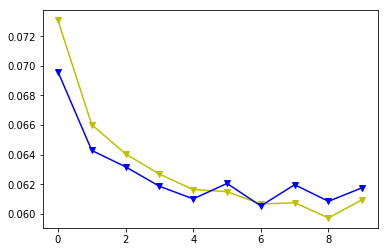

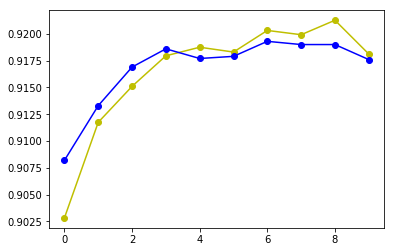

La valeur d'accuracy en test à la dernière itération est de 0.9176


In [5]:
import matplotlib.pyplot as plt
print('The Gradient descent took '+ str(round(test_0[0],3))+' min')
plt.plot(test_0[1],'y',marker='v')
plt.plot(test_0[2],'b',marker='v')
plt.figure()
plt.plot(test_0[3],'y',marker='o')
plt.plot(test_0[4],'b',marker='o')
plt.show()
print("La valeur d'accuracy en test à la dernière itération est de " + str(test_0[4][maxEpoch_test-1]))


# Testons sur différentes tailles de batch et observons les performances

==============  For batch size = 32  ===============
The Gradient descent took 2.035 min


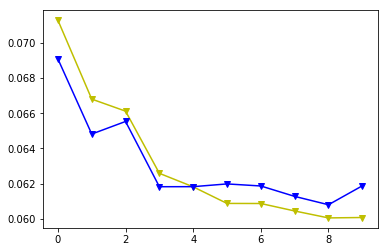

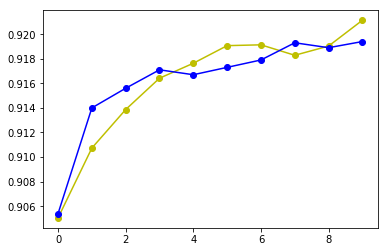

La valeur d'accuracy en test à la dernière itération est de 0.9194
==============  For batch size = 64  ===============
The Gradient descent took 2.011 min


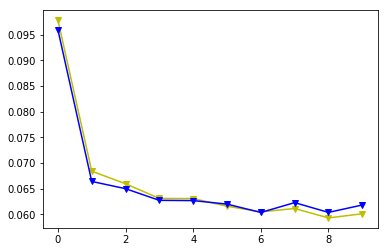

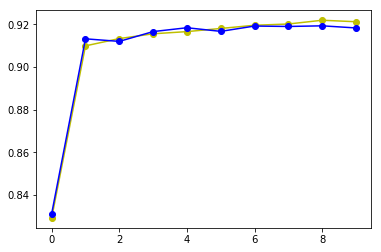

La valeur d'accuracy en test à la dernière itération est de 0.9183
==============  For batch size = 128  ===============
The Gradient descent took 1.851 min


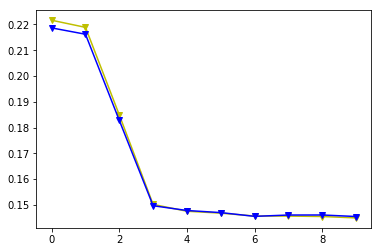

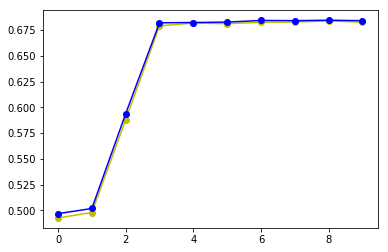

La valeur d'accuracy en test à la dernière itération est de 0.684
==============  For batch size = 256  ===============
The Gradient descent took 1.85 min


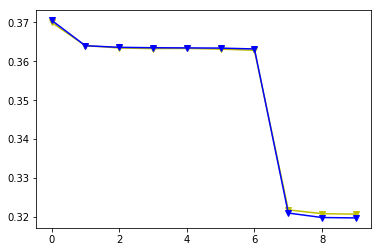

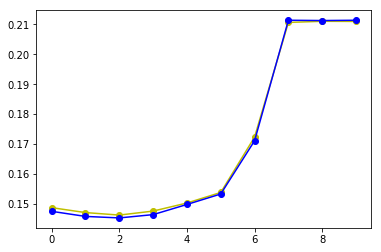

La valeur d'accuracy en test à la dernière itération est de 0.2114
==============  For batch size = 512  ===============
The Gradient descent took 1.76 min


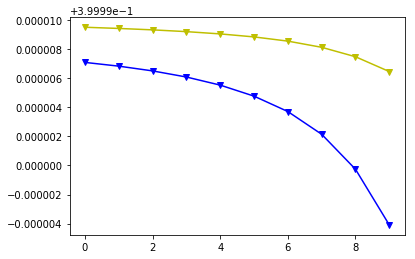

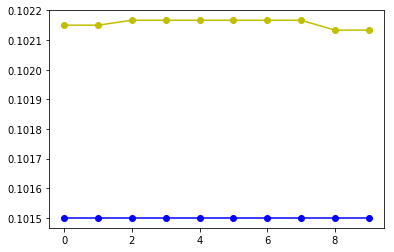

La valeur d'accuracy en test à la dernière itération est de 0.1015
==============  For batch size = 1024  ===============
The Gradient descent took 1.761 min


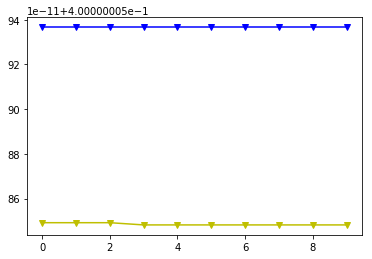

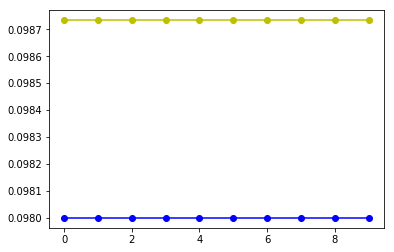

La valeur d'accuracy en test à la dernière itération est de 0.098
==============  For batch size = 2048  ===============
The Gradient descent took 1.775 min


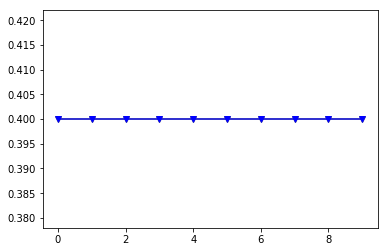

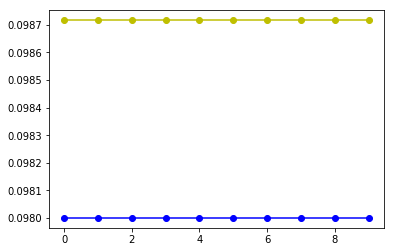

La valeur d'accuracy en test à la dernière itération est de 0.098


In [6]:
i=0
test=dict()
for batch_size_test in [32,64,128,256,512,1024,2048]:
    test[i]  = Gradient_Descent(batch_size=batch_size_test,
                                learning_rate=learning_rate_test,maxEpoch=maxEpoch_test,taille_sortie=10,random_value=random_value_test)  

    print("==============  For batch size = "+str(batch_size_test)+ "  ===============")
    print('The Gradient descent took '+ str(round(test[i][0],3))+' min')
    plt.plot(test[i][1],'y',marker='v')
    plt.plot(test[i][2],'b',marker='v')
    plt.figure()
    plt.plot(test[i][3],'y',marker='o')
    plt.plot(test[i][4],'b',marker='o')
    plt.show()
    print("La valeur d'accuracy en test à la dernière itération est de " + str(test[i][4][maxEpoch_test-1]))
    i+=1

# On se rend compte que les paramètres (learning_rate et random_value, max_Epoch) ne fonctionnent pas bien pour les différents batch size. Essayons d'adapter le Max_epoch à la taille du batch. On augmente le Max_epoch lorsque la taille du batch est grande.

==============  For batch size = 32  ===============
The Gradient descent took 0.394 min


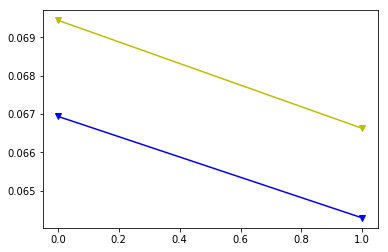

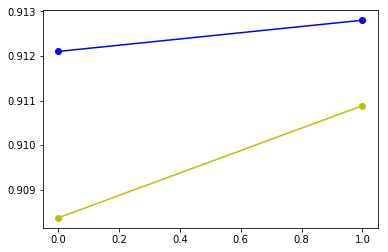

La valeur d'accuracy en test à la dernière itération est de 0.9128
==============  For batch size = 64  ===============
The Gradient descent took 1.817 min


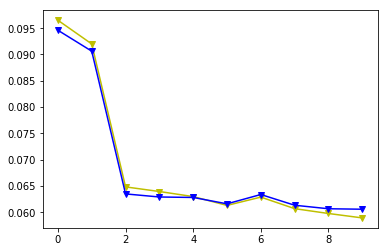

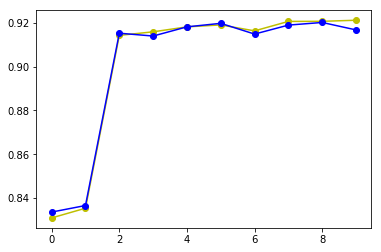

La valeur d'accuracy en test à la dernière itération est de 0.9168
==============  For batch size = 128  ===============
The Gradient descent took 7.59 min


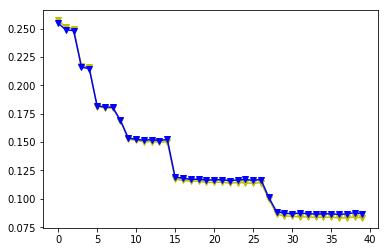

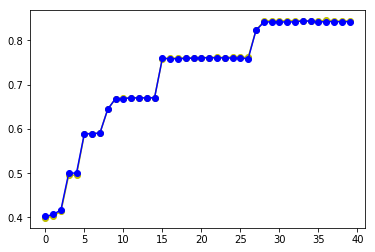

La valeur d'accuracy en test à la dernière itération est de 0.8424
==============  For batch size = 256  ===============
The Gradient descent took 28.902 min


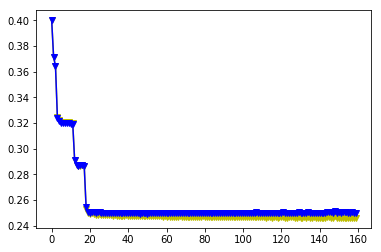

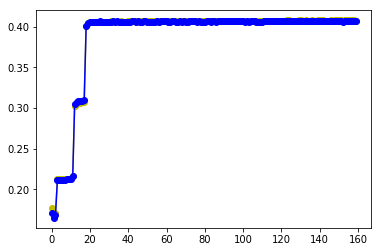

La valeur d'accuracy en test à la dernière itération est de 0.4066
==============  For batch size = 512  ===============
The Gradient descent took 110.839 min


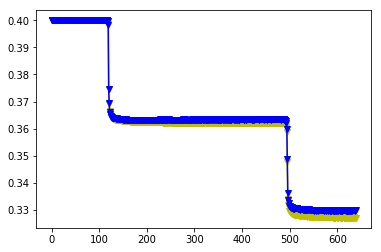

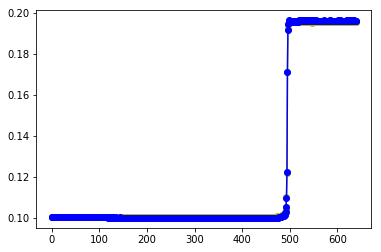

La valeur d'accuracy en test à la dernière itération est de 0.1961


KeyboardInterrupt: 

In [8]:
i=0
test_batch=dict()
for batch_size_test in [32,64,128,256,512]:
    test_batch[i]  = Gradient_Descent(batch_size=batch_size_test,
                                      learning_rate=learning_rate_test,
                                      maxEpoch=int(maxEpoch_test*(batch_size_test/64)**2),
                                      taille_sortie=10,random_value=random_value_test)  

    print("==============  For batch size = "+str(batch_size_test)+ "  ===============")
    print('The Gradient descent took '+ str(round(test_batch[i][0],3))+' min')
    plt.plot(test_batch[i][1],'y',marker='v')
    plt.plot(test_batch[i][2],'b',marker='v')
    plt.figure()
    plt.plot(test_batch[i][3],'y',marker='o')
    plt.plot(test_batch[i][4],'b',marker='o')
    plt.show()
    print("La valeur d'accuracy en test à la dernière itération est de " + str(test_batch[i][4][int(maxEpoch_test*(batch_size_test/64)**2)-1]))
    i+=1

# C'est pas parfait encore mais du progrès

# Construisons maintenant un NN à deux couches

In [11]:
def Gradient_Descent_2_layers(batch_size,learning_rate_1,learning_rate_2,taille_sortie,maxEpoch,random_value):
    train_loader= torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=batch_size, shuffle=True) 
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=batch_size, shuffle=True) 

    
    linear_1 = Flinear()
    linear_2 = Flinear()
    error = FMSE()
    tanh_1 = FTanh()
    tanh_2 = FTanh()
    
    all_losses_global_train=np.zeros(int((maxEpoch)))
    all_losses_global_test=np.zeros(int((maxEpoch)))
    
    accuracy_train=np.zeros(int(maxEpoch))
    accuracy_test=np.zeros(int(maxEpoch))

    theta_1 = torch.randn(28*28,500).uniform_(-random_value,random_value)
    theta_2 = torch.randn(500,10).uniform_(-random_value,random_value)
    
    def all_fun(x): return(tanh_2.forward(linear_2.forward(tanh_1.forward(linear_1.forward(x,theta_1),'useless'),theta_2),'useless2'))
    a=time.time()
    for iteration in range(0,maxEpoch) : 
        for x,y in train_loader:

            target = y 
            y_test = torch.LongTensor(target.unsqueeze(1))
            y2 = torch.FloatTensor(y.size()[0], n).fill_(-1)
            y2 = y2.scatter_(1,y_test,1)

            #Let's propagate
            x= x.view(x.size()[0],28*28)
            out1 = linear_1.forward(x,theta_1) #valeur avec le modele (B,c)
            out2 = tanh_1.forward(out1,'useless_theta') #valeur après le tanh (B,c)
            out3 = linear_2.forward(out2,theta_2)
            out4 = tanh_2.forward(out3,'useless theta')

            #Let's back-prop
            loss= error.forward(out4,y2) #perte de y_prédit et y, (B,1)
            delta= error.backward('useless_theta') #delta (B,c) 

            delta_1 = tanh_2.backward(delta)[0] #(B,c)

            delta_2 = linear_2.backward(delta_1)[0]
            theta_2 = theta_2 - learning_rate_2*linear_2.backward(delta_1)[1]
            
            delta_3 = tanh_1.backward(delta_2)[0]
            
            theta_1 = theta_1 - learning_rate_1*linear_1.backward(delta_3)[1]
            
            
        if(iteration%1==0):
            all_losses_global_train[int(iteration/1)] = 0
            accuracy_train[iteration] = 0
            for x1,y1 in train_loader:
                error1 = FMSE()
                y0 = torch.FloatTensor(y1.size()[0], n).fill_(-1)
                y0 = y0.scatter_(1,torch.LongTensor(y1.unsqueeze(1)),1)
                all_losses_global_train[int(iteration/1)] += sum(error.forward(all_fun(x1.view(x1.size()[0],28*28)),y0))
                accuracy_train[iteration] += sum((torch.max(all_fun(x1.view(x1.size()[0],28*28)).t(),0)[1])==y1)
            all_losses_global_train[int(iteration/1)] /= train_loader.dataset.train_data.size()[0]
            accuracy_train[iteration] /= train_loader.dataset.train_data.size()[0]
            
            all_losses_global_test[int(iteration/1)] = 0
            for x1,y1 in test_loader: 
                error1 = FMSE()
                y0 = torch.FloatTensor(y1.size()[0], n).fill_(-1)
                y0 = y0.scatter_(1,torch.LongTensor(y1.unsqueeze(1)),1)
                all_losses_global_test[int(iteration/1)] += sum(error.forward(all_fun(x1.view(x1.size()[0],28*28)),y0))
                accuracy_test[iteration] += sum((torch.max(all_fun(x1.view(x1.size()[0],28*28)).t(),0)[1])==y1)
            all_losses_global_test[int(iteration/1)] /= test_loader.dataset.test_data.size()[0]
            accuracy_test[iteration] /= test_loader.dataset.test_data.size()[0]
            
    return((time.time()-a)/60,all_losses_global_train,all_losses_global_test,accuracy_train,accuracy_test,theta_1,theta_2)

In [12]:
batch_size_test=64
maxEpoch_test = 10
learning_rate_test = 0.0005

test_2_layers= Gradient_Descent_2_layers(batch_size=batch_size_test,
                                learning_rate_1=learning_rate_test,
                                learning_rate_2=learning_rate_test,
                                maxEpoch=maxEpoch_test,
                                taille_sortie=10,
                                random_value=random_value_test) 

The Gradient descent took 2.869 min


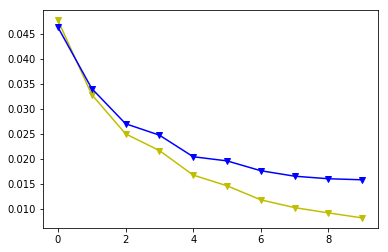

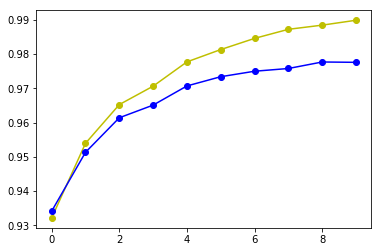

La valeur d'accuracy en test à la dernière itération est de 0.9776


In [13]:
import matplotlib.pyplot as plt
print('The Gradient descent took '+ str(round(test_2_layers[0],3))+' min')
plt.plot(test_2_layers[1],'y',marker='v')
plt.plot(test_2_layers[2],'b',marker='v')
plt.figure()
plt.plot(test_2_layers[3],'y',marker='o')
plt.plot(test_2_layers[4],'b',marker='o')
plt.show()
print("La valeur d'accuracy en test à la dernière itération est de " + str(test_2_layers[4][maxEpoch_test-1]))


# Encore plus performant que le réseau à une couche

# Testons maintenant sur le Mnist avec background image

In [17]:
def load_mnist(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f]
    tmp = np.array(data)
    return tmp[:,:-1],tmp[:,-1].astype(int)
 

train = load_mnist('/Users/melkigabriel/Downloads/mnist_background_images/mnist_background_images_train.amat')
test = load_mnist('/Users/melkigabriel/Downloads/mnist_background_images/mnist_background_images_test.amat')

 
trainset_2 = torch.utils.data.TensorDataset(torch.from_numpy(train[0]).type(torch.FloatTensor), torch.from_numpy(train[1]).type(torch.LongTensor))
testset_2 = torch.utils.data.TensorDataset(torch.from_numpy(test[0]).type(torch.FloatTensor), torch.from_numpy(test[1]).type(torch.LongTensor))
 

batch_size=64
nb_digits=10


In [18]:
def Gradient_Descent_2_layers_2(batch_size,learning_rate_1,learning_rate_2,taille_sortie,maxEpoch,random_value):
    train_loader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size, shuffle=True) 
    test_loader_2 = torch.utils.data.DataLoader(testset_2, batch_size=batch_size, shuffle=True) 
    
    linear_1 = Flinear()
    linear_2 = Flinear()
    error = FMSE()
    tanh_1 = FTanh()
    tanh_2 = FTanh()
    
    all_losses_global_train=np.zeros(int((maxEpoch)))
    all_losses_global_test=np.zeros(int((maxEpoch)))
    
    accuracy_train=np.zeros(int(maxEpoch))
    accuracy_test=np.zeros(int(maxEpoch))

    theta_1 = torch.randn(28*28,500).uniform_(-random_value,random_value)
    theta_2 = torch.randn(500,10).uniform_(-random_value,random_value)
    
    def all_fun(x): return(tanh_2.forward(linear_2.forward(tanh_1.forward(linear_1.forward(x,theta_1),'useless'),theta_2),'useless2'))
    a=time.time()
    for iteration in range(0,maxEpoch) : 
        for x,y in train_loader_2:

            target = y 
            y_test = torch.LongTensor(target.unsqueeze(1))
            y2 = torch.FloatTensor(y.size()[0], n).fill_(-1)
            y2 = y2.scatter_(1,y_test,1)

            #Let's propagate
            x= x.view(x.size()[0],28*28)
            out1 = linear_1.forward(x,theta_1) #valeur avec le modele (B,c)
            out2 = tanh_1.forward(out1,'useless_theta') #valeur après le tanh (B,c)
            out3 = linear_2.forward(out2,theta_2)
            out4 = tanh_2.forward(out3,'useless theta')

            #Let's back-prop
            loss= error.forward(out4,y2) #perte de y_prédit et y, (B,1)
            delta= error.backward('useless_theta') #delta (B,c) 

            delta_1 = tanh_2.backward(delta)[0] #(B,c)

            delta_2 = linear_2.backward(delta_1)[0]
            theta_2 = theta_2 - learning_rate_2*linear_2.backward(delta_1)[1]
            
            delta_3 = tanh_1.backward(delta_2)[0]
            
            theta_1 = theta_1 - learning_rate_1*linear_1.backward(delta_3)[1]
            
            
        if(iteration%1==0):
            all_losses_global_train[int(iteration/1)] = 0
            accuracy_train[iteration] = 0
            for x1,y1 in train_loader_2:
                error1 = FMSE()
                y0 = torch.FloatTensor(y1.size()[0], n).fill_(-1)
                y0 = y0.scatter_(1,torch.LongTensor(y1.unsqueeze(1)),1)
                all_losses_global_train[int(iteration/1)] += sum(error.forward(all_fun(x1.view(x1.size()[0],28*28)),y0))
                accuracy_train[iteration] += sum((torch.max(all_fun(x1.view(x1.size()[0],28*28)).t(),0)[1])==y1)
            all_losses_global_train[int(iteration/1)] /= train_loader_2.dataset.data_tensor.size()[0]
            accuracy_train[iteration] /= train_loader_2.dataset.data_tensor.size()[0]

            all_losses_global_test[int(iteration/1)] = 0
            for x1,y1 in test_loader_2: 
                error1 = FMSE()
                y0 = torch.FloatTensor(y1.size()[0], n).fill_(-1)
                y0 = y0.scatter_(1,torch.LongTensor(y1.unsqueeze(1)),1)
                all_losses_global_test[int(iteration/1)] += sum(error.forward(all_fun(x1.view(x1.size()[0],28*28)),y0))
                accuracy_test[iteration] += sum((torch.max(all_fun(x1.view(x1.size()[0],28*28)).t(),0)[1])==y1)
            all_losses_global_test[int(iteration/1)] /= test_loader_2.dataset.data_tensor.size()[0]
            accuracy_test[iteration] /= test_loader_2.dataset.data_tensor.size()[0]
    
    return((time.time()-a)/60,all_losses_global_train,all_losses_global_test,accuracy_train,accuracy_test,theta_1,theta_2)

In [19]:
batch_size_test=64
maxEpoch_test = 30
learning_rate_test = 0.0005

test_background= Gradient_Descent_2_layers_2( batch_size=batch_size_test,
                                        learning_rate_1=learning_rate_test,
                                        learning_rate_2=learning_rate_test,
                                        maxEpoch=maxEpoch_test,
                                        taille_sortie=10,                                
                                        random_value=random_value_test) 

The Gradient descent took 2.028 min


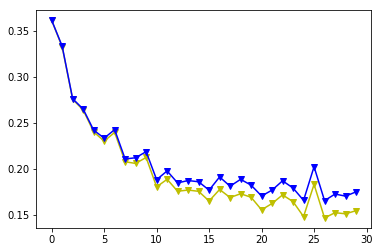

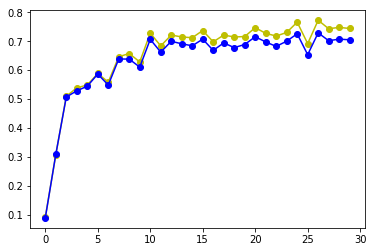

La valeur d'accuracy en test à la dernière itération est de 0.704814096282


In [20]:
import matplotlib.pyplot as plt
print('The Gradient descent took '+ str(round(test_background[0],3))+' min')
plt.plot(test_background[1],'y',marker='v')
plt.plot(test_background[2],'b',marker='v')
plt.figure()
plt.plot(test_background[3],'y',marker='o')
plt.plot(test_background[4],'b',marker='o')
plt.show()
print("La valeur d'accuracy en test à la dernière itération est de " + str(test_background[4][maxEpoch_test-1]))


# On pourrait augmenter le nombre de couches pour avoir de meilleurs résultats.